## Assignment 01

In this task, we will consider the problem of text classification. To achieve better results, we will use informative tag descriptions for words.

In [871]:
# do not change the code in the block below
# __________start of block__________
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# __________end of block__________

### Text preprocessing and tokenization

Preprocessing is almost the same as discussed in the lecture. The `nltk` [link](https://www.nltk.org) library is widely used in word processing. See the link above for a detailed description and documentation.

In [872]:
# do not change the code in the block below
# __________start of block__________
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
texts_train = df[0].values[:5000]
y_train = df[1].values[:5000]
texts_test = df[0].values[5000:]
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

# Small check that everything is done properly
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)
# __________end of block__________

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


The following functions will help you visualize the network learning process.

In [873]:
# do not change the code in the block below
# __________start of block__________
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model,
                               model_name, 
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test, 
                               out_dict):
  
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')
            
        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict
# __________end of block__________

### Task #1. Bag of words.

Use the classic approach to text vectorization: a bag of words. To do this, you can either use the `CountVectorizer` from `sklearn`, or implement it yourself. Please note that in this problem only `k` of the most frequently encountered words from the training part of the sample are used.

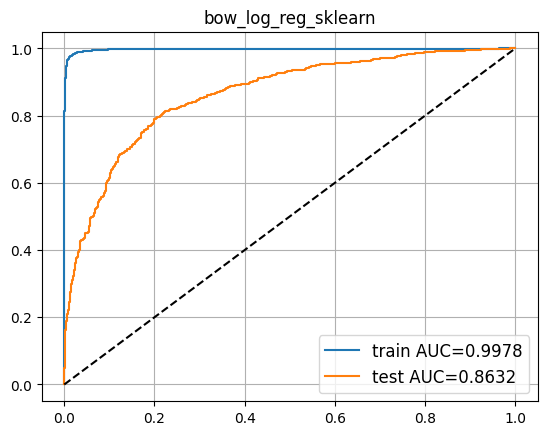

In [751]:
# do not change the code in the block below
# __________start of block__________

k = min(10000, len(set(' '.join(texts_train).split())))

counts = Counter(' '.join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]


def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    sent_vec = np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
        if token in counts:
            sent_vec[i] = counts[token]
    return np.array(sent_vec, 'float32')

X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

# Small check that everything is done properly if you are using local bow implementation
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index('!')] == texts_train[65].split().count('!')


bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(bow_model, 'bow_log_reg_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

In [752]:
len(bow_vocabulary),X_train_bow.shape

(10000, (5000, 10000))

The results are not bad, but overfitting is clearly visible. This conclusion can be drawn judging by the significant quality superiority (AUC ROC) on the train sample relative to the test. Moreover, on the training sample, the quality tends to unity, while on the deferred one it is much lower, i.e. the model captured many dependencies,
…implement a solution based on logistic regression, but already using PyTorch. As a result, you should have a trained model that predicts the probabilities for the two classes. The quality on the test sample should not be inferior to the logistic regression.

In [936]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(k, 2))

Don't forget the loss functions: `nn.CrossEntropyLoss` combines `LogSoftMax` and `NLLLoss`. Also don't forget about the need to transfer the tensors to the used `device`.

In [754]:
loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [755]:
X_train_bow_torch = torch.Tensor(X_train_bow)
X_test_bow_torch = torch.Tensor(X_test_bow)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

In [756]:
X_train_bow_torch.shape

torch.Size([5000, 10000])

The function below will help with model training. Part of the code needs to be implemented by yourself.

In [757]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample batch_size random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)
        
        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

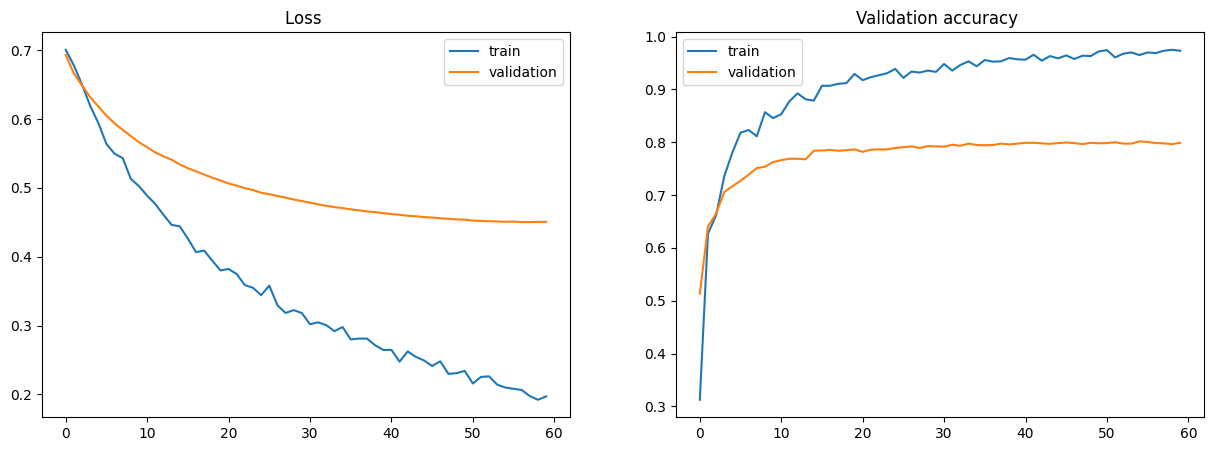

In [758]:
bow_nn_model = train_model(model,
                           opt, 
                           X_train_bow_torch,
                           y_train_torch, 
                           X_test_bow_torch, 
                           y_test_torch, 
                           n_iterations=3000)


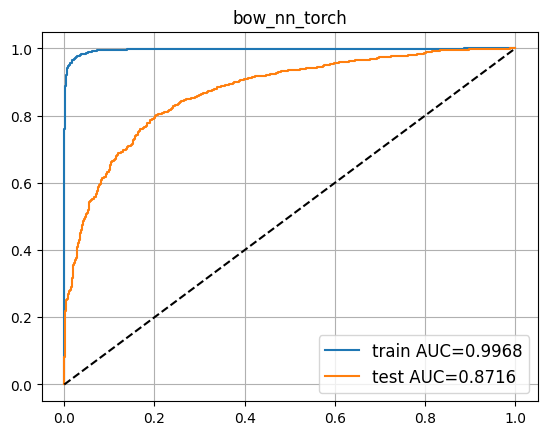

In [759]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(bow_nn_model, 'bow_nn_torch', X_train_bow_torch, X_test_bow_torch, y_train, y_test, out_dict)

assert out_dict['bow_log_reg_sklearn_test'] - out_dict['bow_nn_torch_test'] < 0.01, 'AUC ROC on test data should be close to the sklearn implementation'
# __________end of block__________

Now repeat the training procedure above, but for different values ​​of `k` - the size of the dictionary. In the results list, store the `AUC ROC` on the test sample for the model trained with a dictionary of size `k`.

In [760]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []

for k in vocab_sizes_list:
    # your code here
    counts = Counter(' '.join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    model = nn.Sequential()
    model.add_module('l1', nn.Linear(k, 2))
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)

    X_train_bow_torch = torch.Tensor(X_train_bow)
    X_test_bow_torch = torch.Tensor(X_test_bow)

    y_train_torch = torch.LongTensor(y_train)
    y_test_torch = torch.LongTensor(y_test)
    
    train_model(model, opt, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, show_plots=False)


    predicted_probas_on_test_for_k_sized_dict = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)

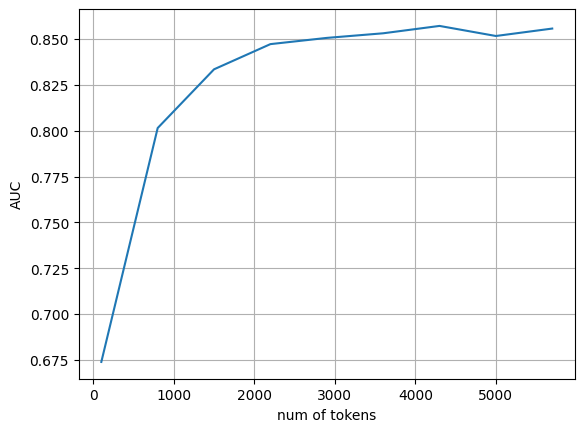

In [761]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.84, 'Best AUC ROC should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['bow_k_vary'] = results
# __________end of block__________

### Task #2: Using TF-iDF features.

You can also use TF-iDF to vectorize texts. This makes it possible to exclude from consideration many words that do not have a significant impact in assessing the dissimilarity of texts.

You can read more about TF-iDF, for example, [here](https://towardsdatascience.com/tf-idf-for-document-ranking-from-
scratch-in-python-on-real-world-dataset-796d339a4089).
You can also read about its independent implementation there.

Your task is to vectorize texts using TF-iDF (or `TfidfVectorizer` from `sklearn`, or implement it yourself) and build a classifier using PyTorch, similar to task #1.
Then also evaluate the quality of the AUC ROC classification for different vocabulary sizes.

The classification quality must be at least 0.86 AUC ROC.

In [839]:
# your code here\
k = min(10000, len(set(' '.join(texts_train).split())))

counts = Counter(' '.join(texts_train).split())

bow_vocabulary = [key for key, val in counts.most_common(k)]

def text_to_tfidf(text,tfidf_vocabulary):
    d = dict.fromkeys(tfidf_vocabulary, 0)
    cnt_D = counts = Counter(text.split())
    for t in text.split():
        if t in tfidf_vocabulary:
            d[t] += 1
    tf = np.array([*d.values()])
    idf = len(text)
    idf /= np.array([cnt_D[w] for w in d]) + 1
    idf = np.log(idf)
    tfidf = tf * idf
    tfidf /= (np.linalg.norm(tfidf) + 1e-2)
    return tfidf
    


In [840]:
#X_train_tfidf = np.stack(list(map(text_to_tfidf, texts_train)))
X_train_tfidf = np.stack(list(
        map(lambda x: text_to_tfidf(x,tfidf_vocabulary=bow_vocabulary), texts_train)))

#X_test_tfidf = np.stack(list(map(text_to_tfidf, texts_test)))
X_test_tfidf = np.stack(list(
        map(lambda x: text_to_tfidf(x,tfidf_vocabulary=bow_vocabulary), texts_test)))



X_train_tfidf_torch = torch.Tensor(X_train_tfidf)
X_test_tfidf_torch = torch.Tensor(X_test_tfidf)

y_train_torch = torch.LongTensor(y_train)
y_test_torch = torch.LongTensor(y_test)

In [841]:
X_test_tfidf_torch.shape

torch.Size([1920, 10000])

In [842]:
model = nn.Sequential()# your code here
model.add_module('l1', nn.Linear(k, 2))


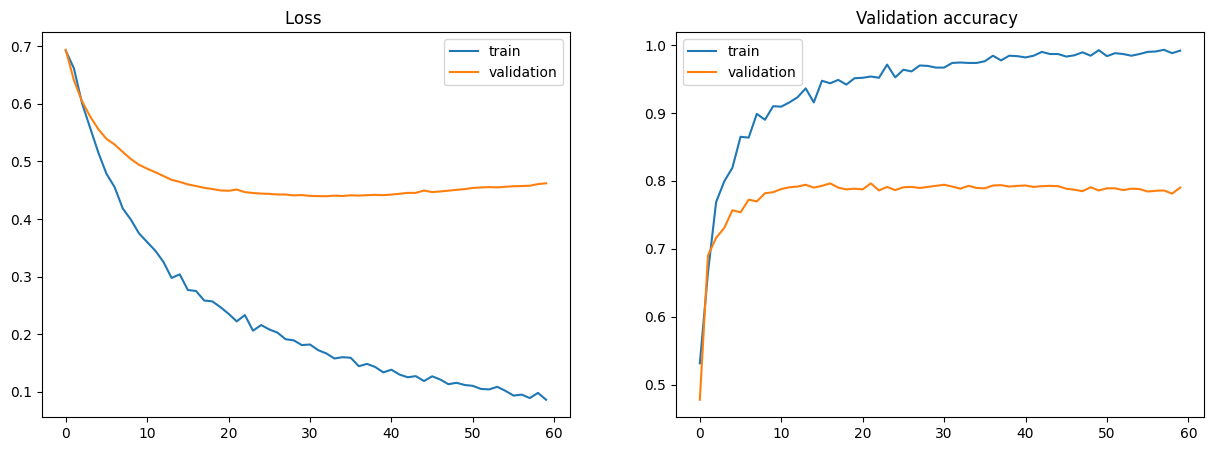

In [843]:
loss_function = nn.CrossEntropyLoss()# your code here
opt = torch.optim.Adam(model.parameters(), lr=1e-2)# your code here

model_tf_idf = train_model(model, 
                           opt, 
                           X_train_tfidf_torch, 
                           y_train_torch, 
                           X_test_tfidf_torch, 
                           y_test_torch, 
                           n_iterations=3000)

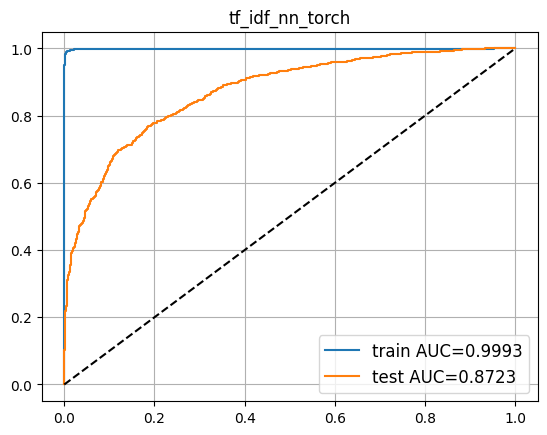

In [844]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)

assert out_dict['tf_idf_nn_torch_test'] >= out_dict['bow_nn_torch_test'], 'AUC ROC on test data should be better or close to BoW for TF-iDF features'
# __________end of block__________

In [845]:
out_dict['tf_idf_nn_torch_test'],out_dict['bow_nn_torch_test']

(0.8723100056428317, 0.871644608160252)

Similar to task #1, repeat the training procedure for different values ​​of `k` - the size of the dictionary and store `AUC ROC` on the test part of the sample in the `results` list.

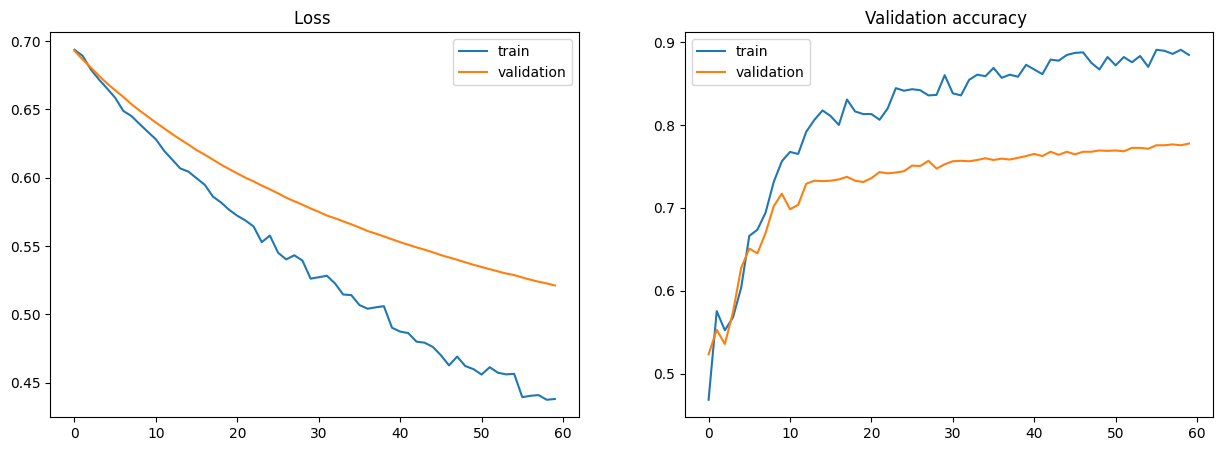

In [846]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []


for k in vocab_sizes_list:
    # your code here
    counts = Counter(' '.join(texts_train).split())
    bow_vocabulary = [key for key, val in counts.most_common(k)]
    tfidf_vocabulary = bow_vocabulary
    
    
    X_train_tfidf = np.stack(list(
        map(lambda x: text_to_tfidf(x,tfidf_vocabulary=bow_vocabulary), texts_train)))

    
    #X_train_bow = np.stack(list(map(text_to_tfidf(bow_vocabulary), texts_train)))
    X_test_tfidf = np.stack(list(
        map(lambda x: text_to_tfidf(x,tfidf_vocabulary=bow_vocabulary), texts_test)))

    model = nn.Sequential()#
    model.add_module('l1', nn.Linear(k, 2))


    loss_function = nn.CrossEntropyLoss()# your code here
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)# your code here
        
   
    X_train_tfidf_torch = torch.Tensor(X_train_tfidf)
    X_test_tfidf_torch = torch.Tensor(X_test_tfidf)

    y_train_torch = torch.LongTensor(y_train)
    y_test_torch = torch.LongTensor(y_test)
    
    model_tf_idf = train_model(model, 
                           opt, 
                           X_train_tfidf_torch, 
                           y_train_torch, 
                           X_test_tfidf_torch, 
                           y_test_torch, 
                           n_iterations=3000)

    predicted_probas_on_test_for_k_sized_dict = model(X_test_tfidf_torch).detach().cpu().numpy()[:, 1]
    assert predicted_probas_on_test_for_k_sized_dict is not None
    auc = roc_auc_score(y_test, predicted_probas_on_test_for_k_sized_dict)
    results.append(auc)


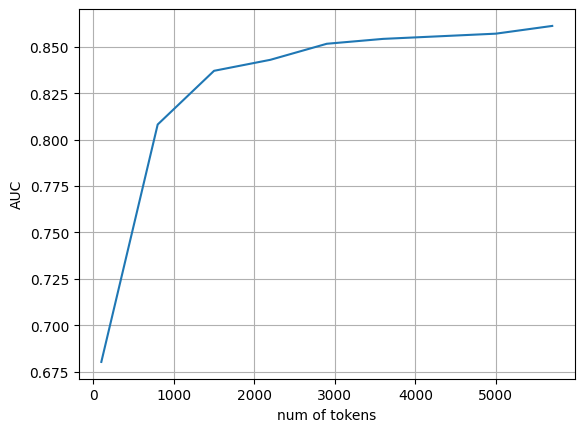

In [847]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), 'Check the code above'
assert min(results) >= 0.65, 'Seems like the model is not trained well enough'
assert results[-1] > 0.85, 'Best AUC ROC for TF-iDF should not be lower than 0.84'

plt.plot(vocab_sizes_list, results)
plt.xlabel('num of tokens')
plt.ylabel('AUC')
plt.grid()

out_dict['tf_idf_k_vary'] = results
# __________end of block__________

### Task #3: Comparison with Naive Bayes classifier.

Classical models are still able to show good results in many problems. Train a naive bayes classifier on texts vectorized with BoW and TF-iDF and compare the results with the models above.

*Comment: please note
it is necessary to choose an a priori distribution for features suitable for this problem, i.e. select the correct classifier version from `sklearn`: `GaussianNB`, `MultinomialNB`, `ComplementNB`, `BernoulliNB`, `CategoricalNB`*

In [850]:
from sklearn.naive_bayes import MultinomialNB# your code here

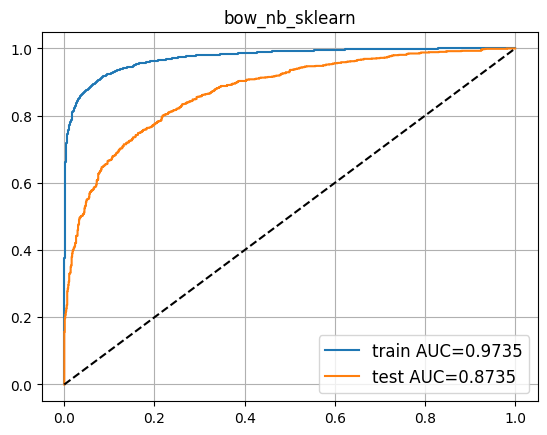

In [851]:
clf_nb_bow = MultinomialNB().fit(X_train_bow, y_train)# your code here

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

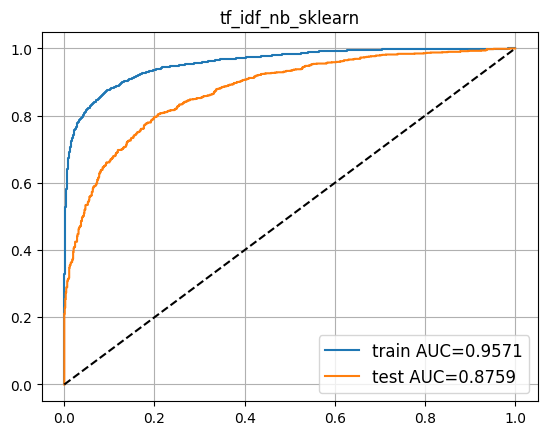

In [852]:
clf_nb_tfidf = MultinomialNB().fit(X_train_tfidf, y_train)# your code here

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [853]:
# do not change the code in the block below
# __________start of block__________
assert out_dict['tf_idf_nb_sklearn_test'] > out_dict['bow_nb_sklearn_test'],' TF-iDF results should be better'
assert out_dict['tf_idf_nb_sklearn_test'] > 0.86, 'TF-iDF Naive Bayes score should be above 0.86'
# __________end of block__________

### Challenge #4: Using pre-trained embeddings

Finally, let's use pre-trained embeddings from the `gensim` library. Several embeddings are available in it, pre-trained on various text corpora. The full list can be found [here](https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models). We remind you
that it is better to use those embeddings that were trained on texts of a similar structure.

Your task: to train the model (logistic regression or a two-layer neural network is enough), using average embedding for all tokens in the recall, to achieve quality no worse than using BoW / TF-
iDF and reduce the degree of overfitting (the difference between the AUC ROC on the training and test sets).

In [1035]:
import gensim.downloader as api
gensim_embedding_model = api.load("glove-wiki-gigaword-100")

In [1386]:
np.mean(gensim_embedding_model.get_vector('hi'))

0.047235757

In [1387]:
def text_to_average_embedding(text, gensim_embedding_model):
    # your code here
    dim = gensim_embedding_model.vector_size
    embedding_for_text = np.zeros(dim, dtype='float32')
    for token in text.split():
        try:
          embedding_for_text += gensim_embedding_model.get_vector(token)
        except KeyError:
          pass
                 
    return embedding_for_text

In [1388]:
X_train_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_train]
X_test_emb = [text_to_average_embedding(text, gensim_embedding_model) for text in texts_test]

assert len(X_train_emb[0]) == gensim_embedding_model.vector_size, 'Seems like the embedding shape is wrong'

In [1389]:
X_train_emb_torch = torch.Tensor(X_train_emb)# your code here
X_test_emb_torch = torch.Tensor(X_test_emb)# your code here

y_train_torch = torch.LongTensor(y_train)# your code here
y_test_torch = torch.LongTensor(y_test)# your code here


In [1390]:
model= nn.Sequential()#
model.add_module('l1', nn.Linear(100, 2))


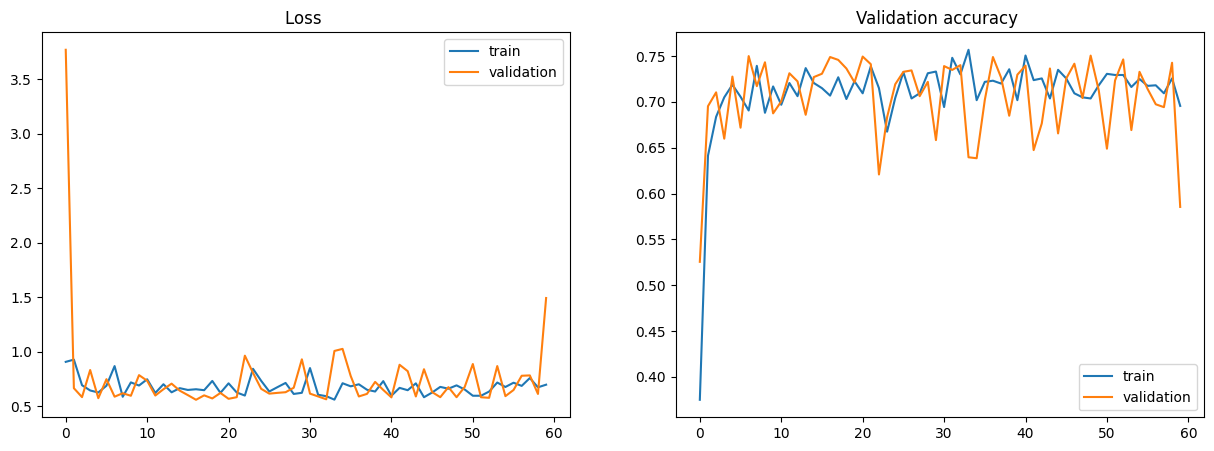

In [1391]:
loss_function = nn.CrossEntropyLoss()# your code here
#opt = torch.optim.Adam(model.parameters(), lr=1e-2)# your code here

opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
#opt = torch.optim.Adam(model.get_params,lr=1e-2)
model = train_model(model, 
                    opt, 
                    X_train_emb_torch, 
                    y_train_torch, 
                    X_test_emb_torch, 
                    y_test_torch, 
                    n_iterations=3000)

AssertionError: ignored

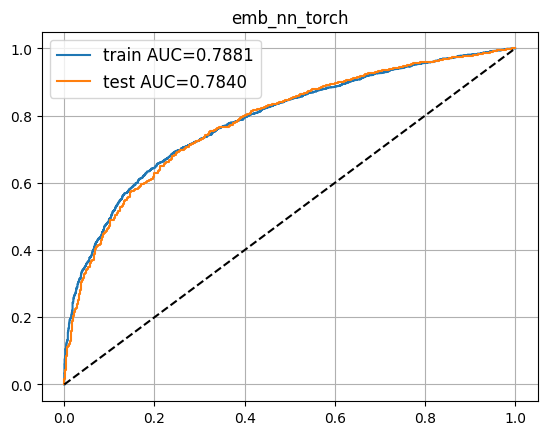

In [1393]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(model, 'emb_nn_torch', X_train_emb_torch, X_test_emb_torch, y_train, y_test, out_dict)
assert out_dict['emb_nn_torch_test'] > 0.87, 'AUC ROC on test data should be better than 0.86'
assert out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test'] < 0.1, 'AUC ROC on test and train data should not be different more than by 0.1'
# __________end of block__________

In [1394]:
out_dict['emb_nn_torch_test'],out_dict['emb_nn_torch_train'] - out_dict['emb_nn_torch_test']

(0.7840252416143065, 0.004043654512374095)

### Сдача задания
Запустите код ниже для генерации посылки и сдайте на проверку файл `submission_dict_101.npy`.

In [1395]:
# do not change the code in the block below
# __________start of block__________

np.save('submission_dict_101.npy', out_dict, allow_pickle=True)
print('File saved to `submission_dict_101.npy`')
# __________end of block__________

File saved to `submission_dict_101.npy`
